In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Чтение датасета

In [36]:
file_path = 'data.xlsx'

df = pd.read_excel(file_path)

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Обработка данных: удаления строк с пропущенными значениями

In [37]:
df.info()

df.isnull().sum()

df = df.dropna()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


Группировка данных по CustomerID и вычисление суммарной стоимости покупок, количества покупок и количества купленных товаров


In [39]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

customer_data = df.groupby('CustomerID').agg({
    'TotalPrice': 'sum', 
    'InvoiceNo': 'count', 
    'Quantity': 'sum'
}).rename(columns={'InvoiceNo': 'InvoiceCount'})

customer_data.head()

,TotalPrice,InvoiceCount,Quantity
CustomerID,,,
12346.0,0.00,2,0
12347.0,4310.00,182,2458
12348.0,1797.24,31,2341
12349.0,1757.55,73,631
12350.0,334.40,17,197


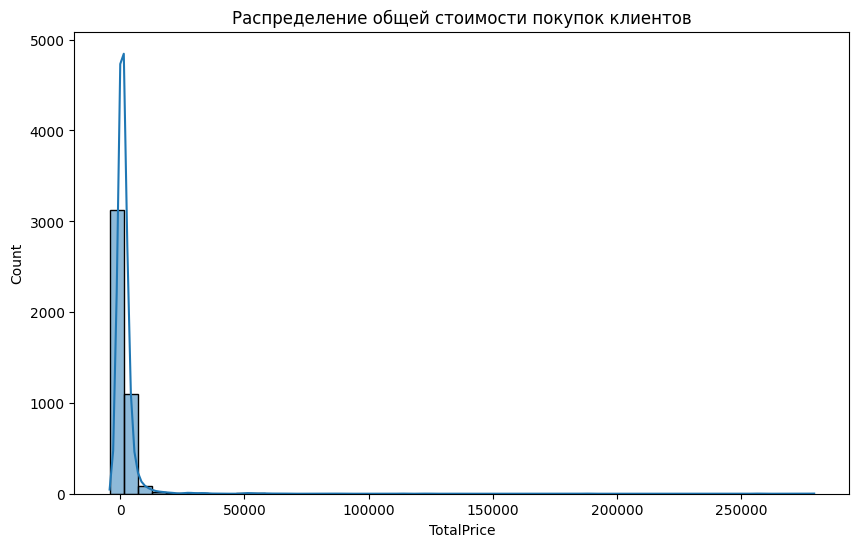

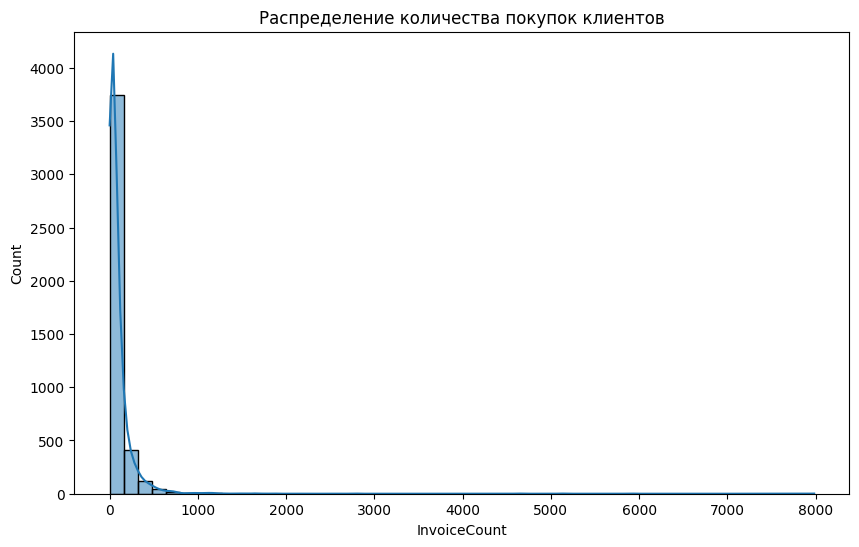

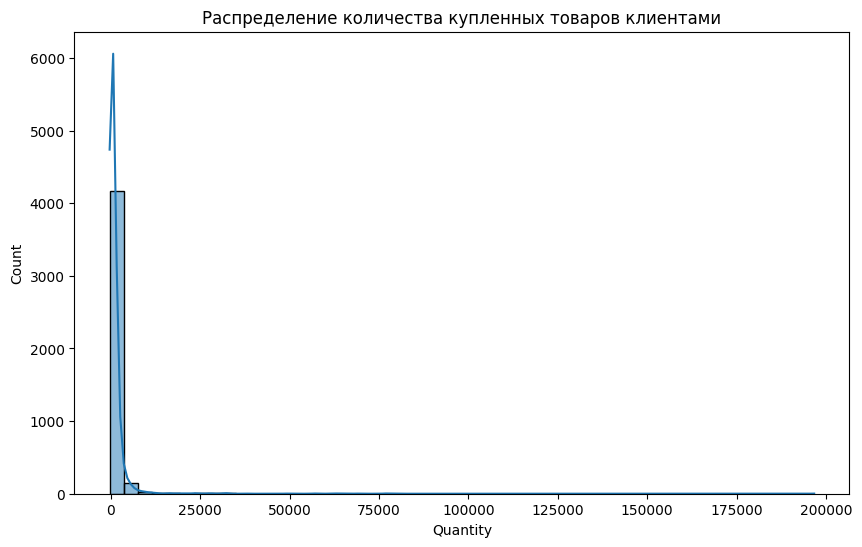

In [40]:
customer_data.describe()

plt.figure(figsize=(10, 6))
sns.histplot(customer_data['TotalPrice'], bins=50, kde=True)
plt.title('Распределение общей стоимости покупок клиентов')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(customer_data['InvoiceCount'], bins=50, kde=True)
plt.title('Распределение количества покупок клиентов')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(customer_data['Quantity'], bins=50, kde=True)
plt.title('Распределение количества купленных товаров клиентами')
plt.show()

Удаление аномальных значений

In [41]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

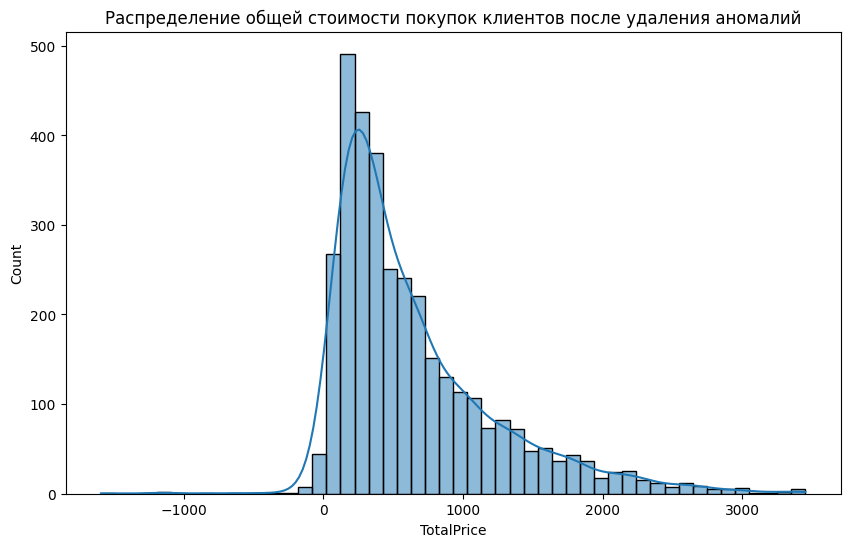

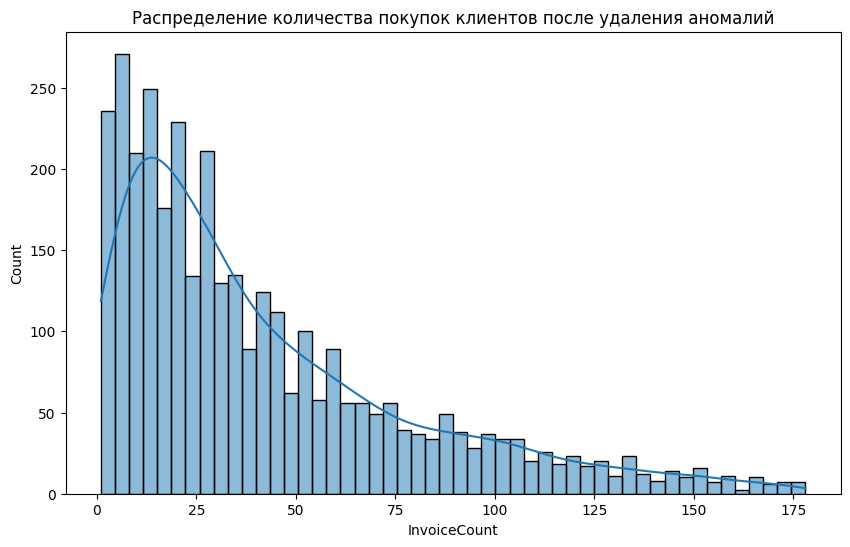

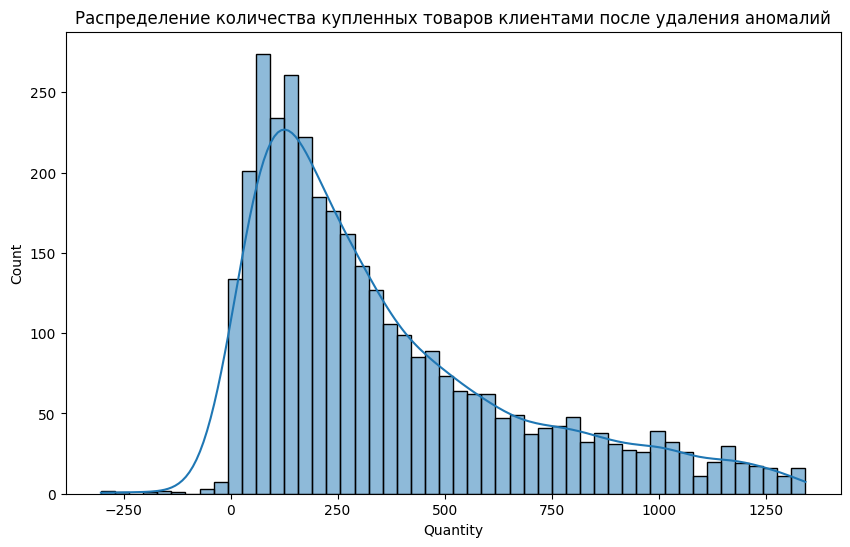

In [42]:
customer_data = remove_outliers(customer_data, 'TotalPrice')
customer_data = remove_outliers(customer_data, 'InvoiceCount')
customer_data = remove_outliers(customer_data, 'Quantity')

customer_data.describe()

plt.figure(figsize=(10, 6))
sns.histplot(customer_data['TotalPrice'], bins=50, kde=True)
plt.title('Распределение общей стоимости покупок клиентов после удаления аномалий')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(customer_data['InvoiceCount'], bins=50, kde=True)
plt.title('Распределение количества покупок клиентов после удаления аномалий')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(customer_data['Quantity'], bins=50, kde=True)
plt.title('Распределение количества купленных товаров клиентами после удаления аномалий')
plt.show()

Стандартизация данных и определение оптимального числа кластеров с помощью метода локтя

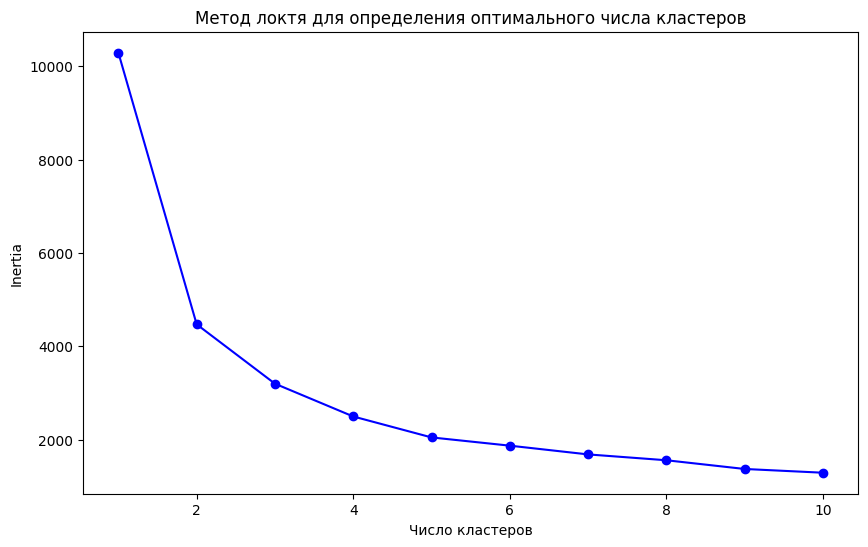

In [43]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data)

inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Число кластеров')
plt.ylabel('Inertia')
plt.title('Метод локтя для определения оптимального числа кластеров')
plt.show()

Обучение модели K-Means с оптимальным числом кластеров (например, k=3)

In [44]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

customer_data['Cluster'] = clusters
customer_data.head()

,TotalPrice,InvoiceCount,Quantity,Cluster
CustomerID,,,,
12346.0,0.00,2,0,1
12349.0,1757.55,73,631,2
12350.0,334.40,17,197,1
12352.0,1545.41,95,470,0
12353.0,89.00,4,20,1


Применим PCA для уменьшения размерности данных до 2 компонентов для визуализации


In [45]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters

Визуализация кластеров

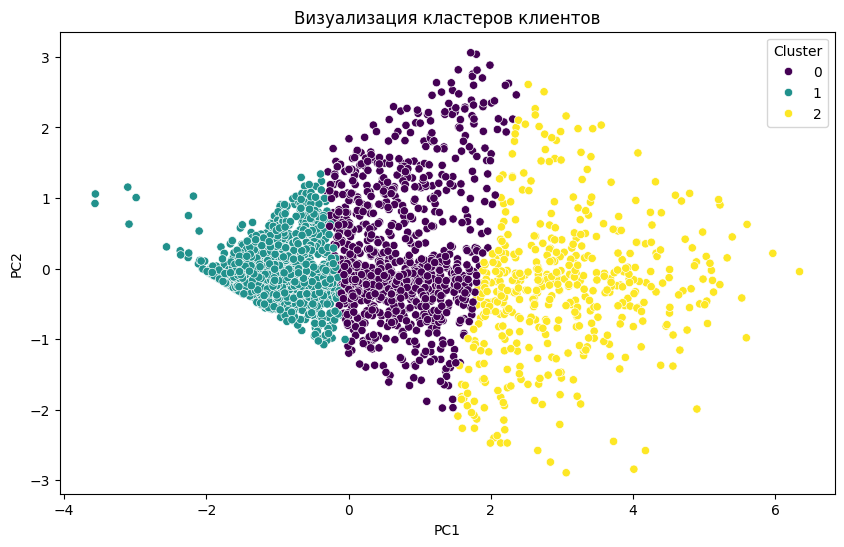

In [46]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='viridis')
plt.title('Визуализация кластеров клиентов')
plt.show()